In [1]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

In [2]:
data = pd.read_pickle('./datasets/data_400.pickle')

In [3]:
texts = [' '.join(d) for d in data['text'].to_list()]
labels = data['genre'].to_list()

In [4]:
texts

["чэндлеp раймонд глубокий сон 1 половина октябрь около одиннадцать утро хмурый типичный это время год предгорие день предвещать холодный секущий дождь светлоголубой рубашка соответствовать галстук платочек кармашек чёрный брюки чёрный носка голубой узор элегантный чистый свежевыбритый полный спокойствие беспокоиться впечатление это производить выглядеть точно должный выглядеть одетый частный детектив идти визит четыре миллион доллар большой холл семейный дом стернвуд этаж высота дверь который легко пройти стадо индийский слон размещаться витраж изображать рыцарь чёрный лата спасать дама привязать дерево дама раздетый нагоя тело окутывать покрывало волос удобство рыцарь поднять забрало пытаться усилие развязать верёвка который дама привязать дерево смотреть витраж думать жить дом рано поздно прийтись влезть наверх помочь рыцарь похоже делать свой дело всерьёз огромный застеклить дверь сторона холл широкий изумрудный газон простираться вплоть белый гараж который молодой щуплый черноволо

In [5]:
maxlen = 400  #Отсечение остатка после 100-го слова
max_words = 10000

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 53219 unique tokens.


In [8]:
d = pad_sequences(sequences, maxlen=maxlen)

In [9]:
labels = np.asarray(labels)
print('Shape of data tensor:', d.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (3662, 400)
Shape of label tensor: (3662,)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(d, labels,
                                                    train_size=0.67,
                                                    random_state=42,
                                                    stratify=labels)
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [ 672 1333  448]
Количество строк в y_test по классам: [331 657 221]


In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
# sentences = list(map(list, data['text'].to_list()))
# model_w2v = Word2Vec(sentences=sentences, vector_size=100, sg=0, window=10, epochs=5, min_count=10, workers=4)
# model_w2v.save('./models/model_w2v.w2v')
model_w2v = Word2Vec.load('./models/model_w2v.w2v')

In [13]:
model_w2v.wv.get_vector('эрагон')

array([ 3.0482090e+00,  9.4848001e-01, -2.5640484e-02, -2.6125648e+00,
        5.6898898e-01, -9.5329922e-01, -9.2685997e-01, -4.9623397e-01,
       -2.1183948e-01,  1.7654988e+00, -1.4585906e+00, -2.4874208e+00,
        4.1608509e-01,  1.6898789e+00, -4.0108457e+00, -1.1662774e+00,
        1.3033429e+00,  5.0580388e-01,  1.8779949e+00, -3.7146640e+00,
       -1.5926567e+00, -6.1159104e-01,  1.4326479e+00, -6.2672621e-01,
        2.4401000e+00,  6.5440923e-01, -2.2412882e+00, -1.1884363e+00,
       -1.8767666e+00,  2.2727141e+00, -1.6965883e+00,  1.1043284e+00,
       -2.1409173e+00,  4.2544499e-01, -3.6678252e+00, -1.7966461e-01,
       -8.8213062e-01, -2.2028422e+00, -2.8675184e-01, -1.5144138e+00,
       -8.6952746e-01,  1.8636987e-01, -1.0440869e-01, -1.0298508e+00,
        4.5000011e-01,  1.3706760e+00, -1.8150887e+00, -3.4587798e+00,
       -3.6314552e+00,  3.1348765e+00, -1.0319283e+00,  5.5976284e-01,
       -1.3901724e+00, -1.4798909e+00,  3.6722204e-01, -1.8083674e+00,
      

In [14]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in model_w2v.wv.key_to_index:
            embedding_vector = model_w2v.wv.get_vector(word)
        else:
            embedding_vector = np.zeros(embedding_dim)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1888762 ,  0.58320308,  0.26507655, ..., -1.25532854,
         0.11306992,  1.24214518],
       [-1.6713419 ,  0.989887  ,  0.1383269 , ..., -0.55382746,
        -0.04980406,  0.47990805],
       ...,
       [-0.03602665,  0.12445448,  0.06156644, ..., -0.13681443,
         0.06839494,  0.13190131],
       [ 0.00232697,  0.03287196,  0.04246398, ..., -0.04966859,
        -0.06785379,  0.10233437],
       [-0.0894557 ,  0.19240478,  0.1181412 , ..., -0.15561093,
         0.0688927 ,  0.11995248]])

In [ ]:
# имя каталога для сохранения результатов:
output_dir = 'model_output/cnn/'
# обучение:
epochs = 10
batch_size = 128

# архитектура сверточного слоя:
n_conv = 256 # фильтры, они же ядра
k_conv = 3 # длина ядра

# архитектура полносвязанного слоя:
n_dense = 256
dropout = 0.2

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(3, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

In [ ]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir +
                                           "weights.{epoch:02d}.hdf5")

In [ ]:


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[modelcheckpoint])
model.save_weights(output_dir + 'self_trained_w2v_model.h5')

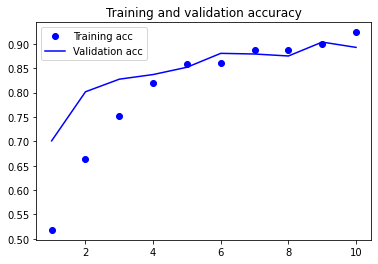

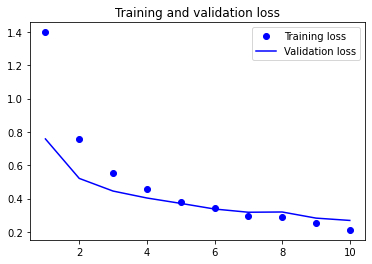

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
model.evaluate(X_test, y_test)

38/38 [==============================] - 1s 23ms/step - loss: 0.2539 - acc: 0.8999


[0.25387251377105713, 0.8999173045158386]

In [22]:
predicted = model.predict(X_test)

In [23]:
GENRES = {'detective': 0,
          'fantasy': 1,
          'sci-fi': 2
          }
genres_list = ['detective','fantasy','sci-fi']

In [24]:
genres = []
for i in predicted[:5]:
    genres.append(genres_list[i.argmax()])

In [25]:
genres

['fantasy', 'detective', 'sci-fi', 'fantasy', 'detective']

In [26]:
y_test[:5]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [27]:
text = tokenizer.sequences_to_texts(X_test[:5])

In [28]:
text

['ночь пройти спокойно рассвет раздаться отдалить грохот появиться зарево подумать сын небо погибнуть вскочить лодка полететь убежище аэлит также слышать взрыв высота скала глядеть сказать мальчик « вернуться усадьба ждать сын небо схватить слуга тускуба умереть молча сын небо убить пробраться труп найти немой каменный привезти » лось стиснуть зуб выслушать рассказ мальчик затем лось гусев послать озеро смыть кровь пыль гусев вырезать крепкий дерево дубина малое лошадиный нога сель лодка взвиться сиять синева гусев завести лодка пещера лечь вход развернуть карта это время сверху скала скатиться иха глядеть гусев взяться щека слеза ручей литься влюбить глаз гусев радостно засмеяться лось спуститься пропасть священный порог крыло ветер нести крутой лесенка узкий переход мостик спастись погибнуть соображать начинать думать бросать главное потрясать снова увидеть « родить свет звезда » лишь голубоватый лицо забыть волна радость стремительно облако пара мост пещерный озеро лось прошлый увид